In [2]:
import pandas as pd
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import clear_output


# Tratamento Inicial

In [3]:
with open('database/df.pkl', 'rb') as f:
    df = pd.read_pickle(f)
df.rename(columns={'year_month': 'date'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df = df.sort_index()
df = df.loc['2013-01-01':'2016-12-31']

In [4]:
oil_prices = df['oil_price']
oil_prices = oil_prices[~oil_prices.index.duplicated(keep='first')]
oil_prices.head(1)

date
2013-01-01    94.756667
Name: oil_price, dtype: float64

In [5]:
df_item = df[df['item_nbr'] == 870938]

# Checando Sazonalidade

Foi observada uma certa sazonalidade nos dados para df_item,  
com essa premissa que abordaremos o uso dos modelos abaixo.

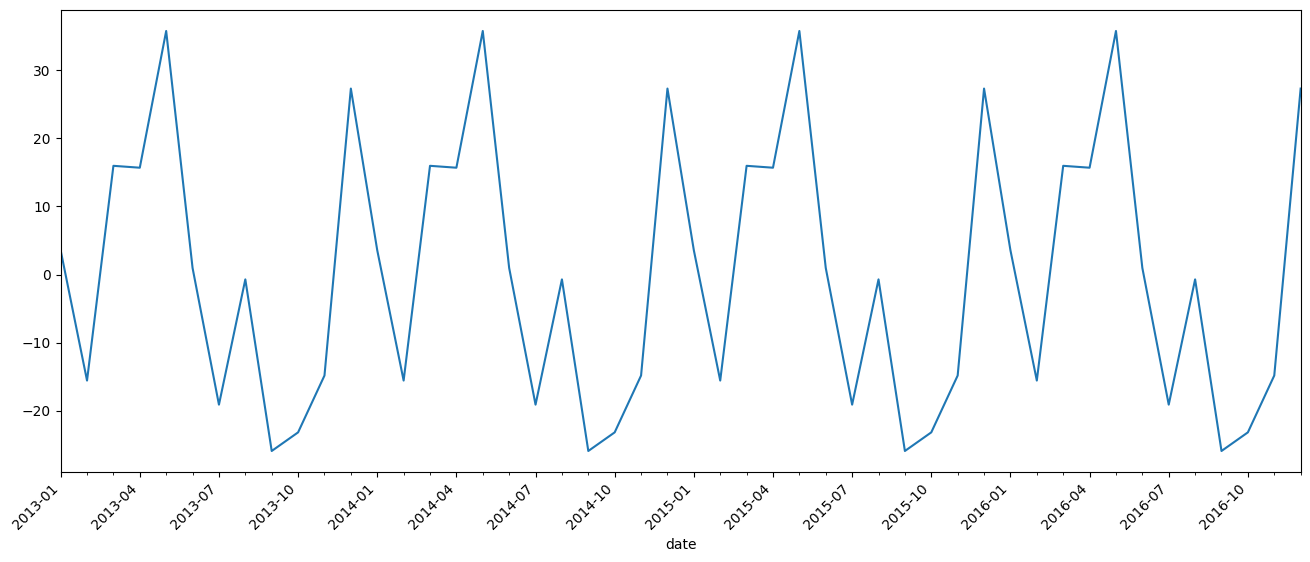

In [6]:
result = seasonal_decompose(df_item['unit_sales'], model='additive', period=12)
seasonal = result.seasonal

# Gerando ticks a cada 3 meses
xticks = pd.date_range(start=df_item.index.min(), end=df_item.index.max(), freq='3ME')

# Plotando o componente sazonal
fig, ax = plt.subplots(figsize=(16, 6))
seasonal.plot(ax=ax)

# Definindo os ticks e rótulos no eixo x para cada 3 meses
ax.set_xticks(xticks)
ax.set_xticklabels([tick.strftime('%Y-%m') for tick in xticks], rotation=45, ha='right')

plt.show()

## Utilizando ARIMA

![chart.png](img/chart.png)

Percebe-se que a média móvel se ajusta bem aos dados.  
ARIMA nesse caso é uma boa opção como modelo.

In [7]:
def plot_forecast(ts, test, forecast):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(ts, label='Original')
    ax.plot(test.index, test, label='Teste', color='red', alpha=0.8)
    ax.plot(test.index, forecast, label='Previsão', color='orange', alpha=0.8, linestyle='--')
    ax.legend()
    return ax

In [8]:
ts = df_item['unit_sales']

train = ts.iloc[:-12]
test = ts.iloc[-12:]

MSE: 4921.882187638844


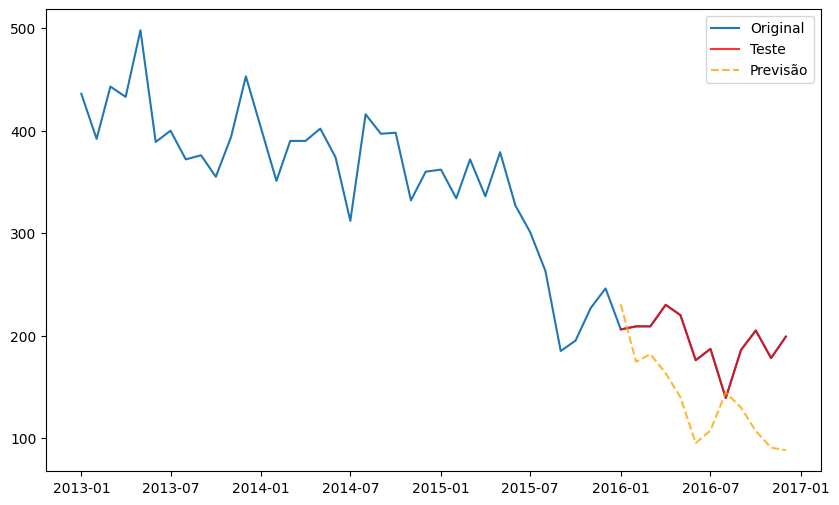

In [9]:
# Ajustar o modelo ARIMA
# p: lag 12 para capturar a sazonalidade
# d: 1 para fazer a série estacionária (foi visto que originalmente ela não é estacionária)
# q: 3 para habilitar média móvel de ordem 3
model = ARIMA(train, order=(12, 1, 3))  # (p, d, q) são os parâmetros do modelo ARIMA
model_fit = model.fit()
 
# Fazer previsões
forecast = model_fit.forecast(steps=12)
plot_forecast(ts, test, forecast)

clear_output()
mse = mean_squared_error(test, forecast)
print(f'MSE: {mse}')

plt.show()

MSE: 818.9321045261995


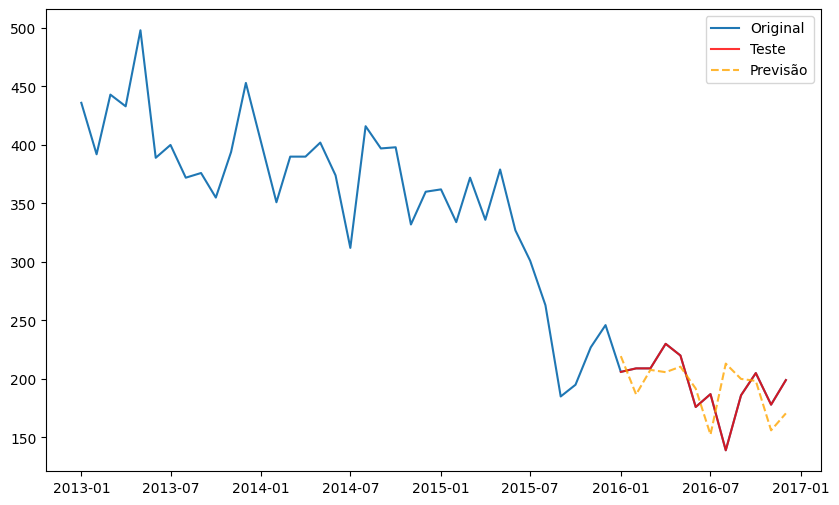

In [10]:
# using AUTOARIMA
# Best model:  ARIMA(0,1,1)(2,0,0)[12] intercept
# Total fit time: 36.557 seconds
# using above settings for ARIMA

model = auto_arima(train, 
                    seasonal=True, 
                    m=12,         
                    stepwise=False,
                    )

model.fit(train)
forecast = model.predict(n_periods=12)
plot_forecast(ts, test, forecast)

clear_output()
mse = mean_squared_error(test, forecast)
print(f'MSE: {mse}')

plt.show()

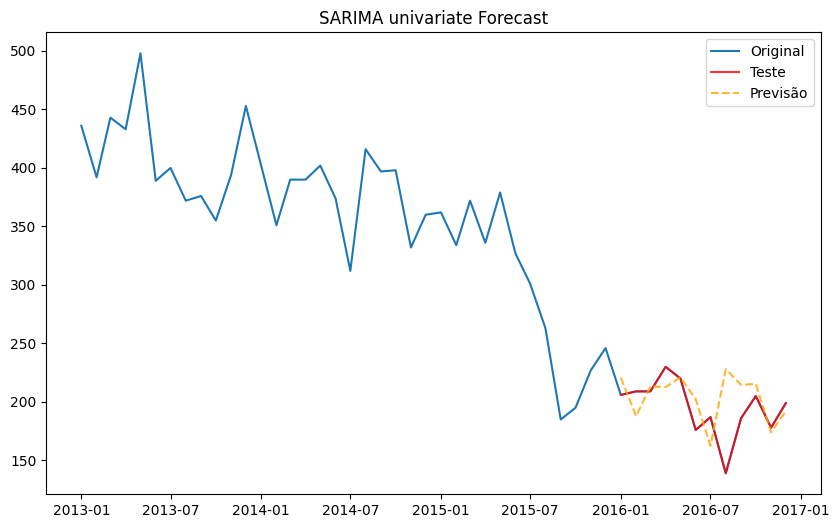

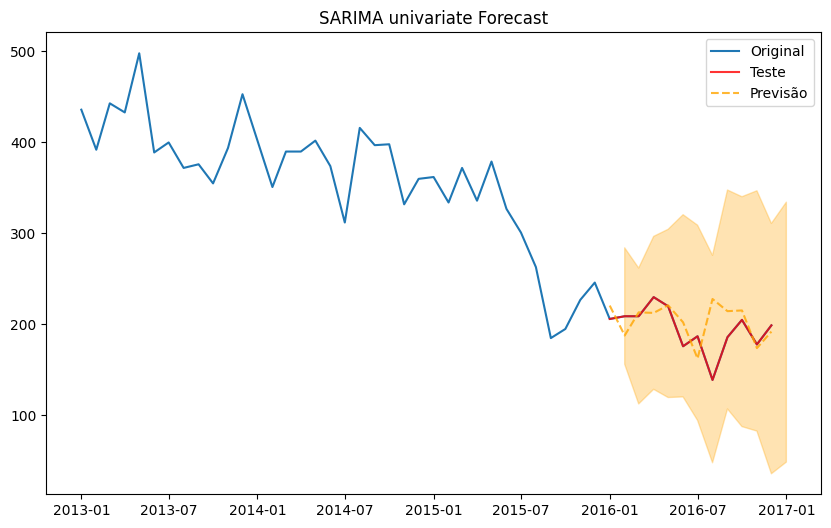

MSE: 931.8443809916204


In [13]:
# using SARIMAX after getting best parameters from AUTOARIMA
# Best model:  ARIMA(0,1,1)(2,0,0)[12] intercept
# Total fit time: 36.557 seconds
# using above settings for ARIMA

ts = df_item['unit_sales']

train = ts.iloc[:-12]
test = ts.iloc[-12:]

model = SARIMAX(train,
                order=(0, 1, 1),
                seasonal_order=(2, 0, 0, 12),
                )

results = model.fit()

forecast = results.get_forecast(steps=12)
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

clear_output()
forecast_index = pd.date_range(start=test.index[0], periods=len(forecast_values), freq='ME')

ax = plot_forecast(ts, test, forecast_values)

ax.set_title('SARIMA univariate Forecast')

plt.show()

ax = plot_forecast(ts, test, forecast_values)

ax.fill_between(
    forecast_index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='orange',
    alpha=0.3
)

ax.set_title('SARIMA univariate Forecast')

plt.show()

mse = mean_squared_error(test, forecast_values)
print(f'MSE: {mse}')

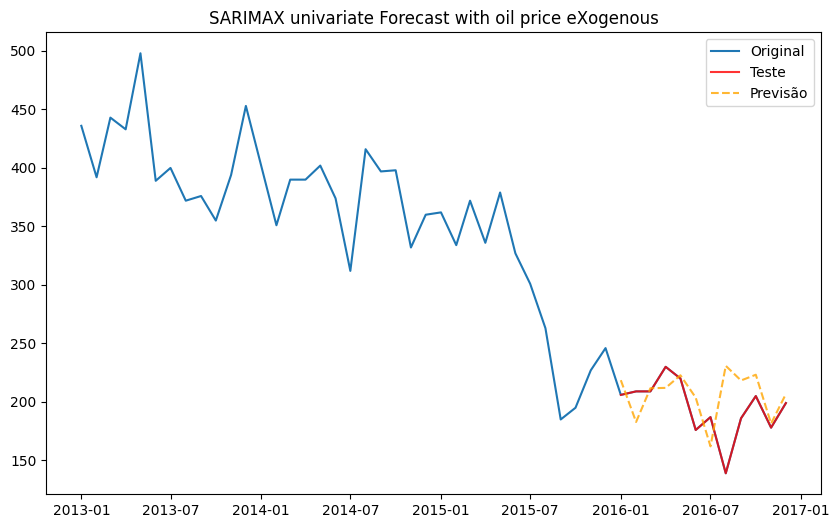

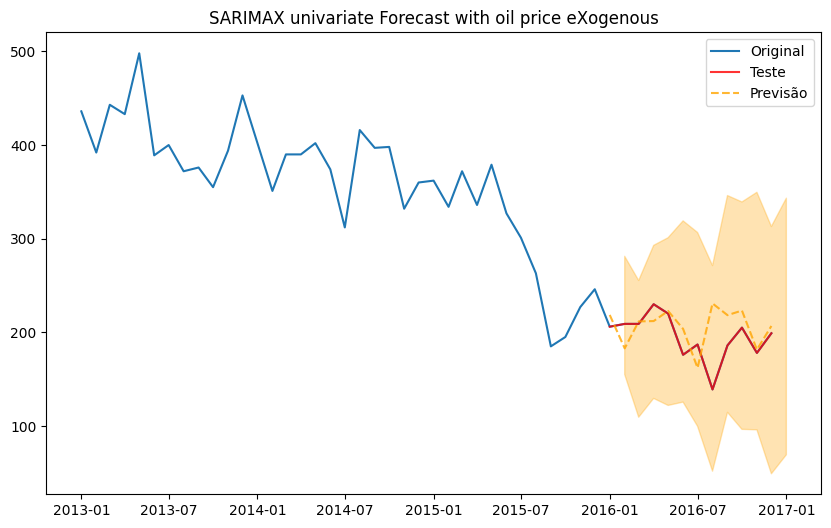

MSE: 1037.9863354568433


In [14]:
# Using SARIMAX with eXogenous
# Best model:  ARIMA(0,1,1)(2,0,0)[12] intercept
# Total fit time: 36.557 seconds
# using above settings for ARIMA


ts = df_item['unit_sales']

train = ts.iloc[:-12]
test = ts.iloc[-12:]

model = SARIMAX(train,
                order=(0, 1, 1),
                seasonal_order=(2, 0, 0, 12),
                exog=oil_prices.loc[train.index],
                )

results = model.fit()

forecast = results.get_forecast(steps=12, exog=oil_prices.loc[test.index])
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

clear_output()
forecast_index = pd.date_range(start=test.index[0], periods=len(forecast_values), freq='ME')

ax = plot_forecast(ts, test, forecast_values)

ax.set_title('SARIMAX univariate Forecast with oil price eXogenous')

plt.show()

ax = plot_forecast(ts, test, forecast_values)

ax.fill_between(
    forecast_index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='orange',
    alpha=0.3
)


ax.set_title('SARIMAX univariate Forecast with oil price eXogenous')

plt.show()

mse = mean_squared_error(test, forecast_values)
print(f'MSE: {mse}')